## pip installations

In [ ]:
!pip install -U scikit-learn

In [4]:
# Import a bunch of initial stuff

import glob
import os
import sklearn

import colour
import numpy as np
from colour.hints import ArrayLike, Any

# For inference
from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    detect_colour_checkers_inference,
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

# For segmentation
from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    detect_colour_checkers_segmentation,
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

# Templating
from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    detect_colour_checkers_templated,
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC    *
*   v.1944 64 bit (AMD64)]                                                    *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.7                                                        *
*       colour-checker-detection : 0.2.3                                      *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.37.2                                                      *
*       matplotlib : 3.10.8                                                   *
*       networkx : 3.6.1                

# Image processing

Trimmed (2%) and Padded (30%): ColorTest\colortest1.jpg
Trimmed (2%) and Padded (30%): ColorTest\colortest2.jpg
Trimmed (2%) and Padded (30%): ColorTest\colortest3.jpg


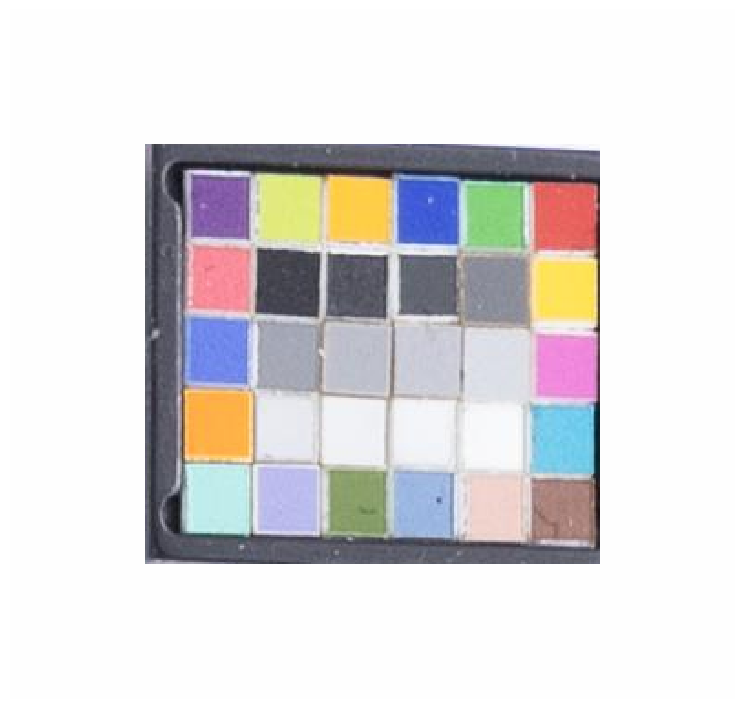

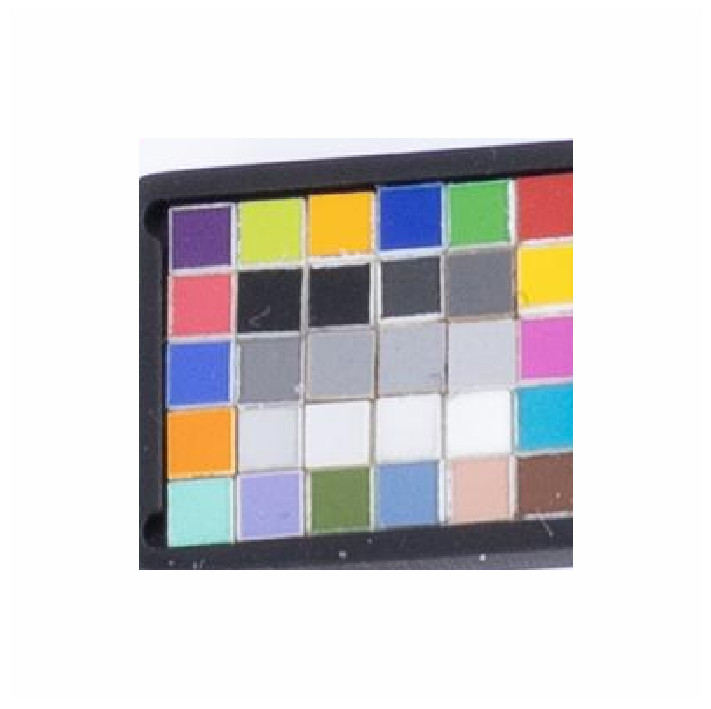

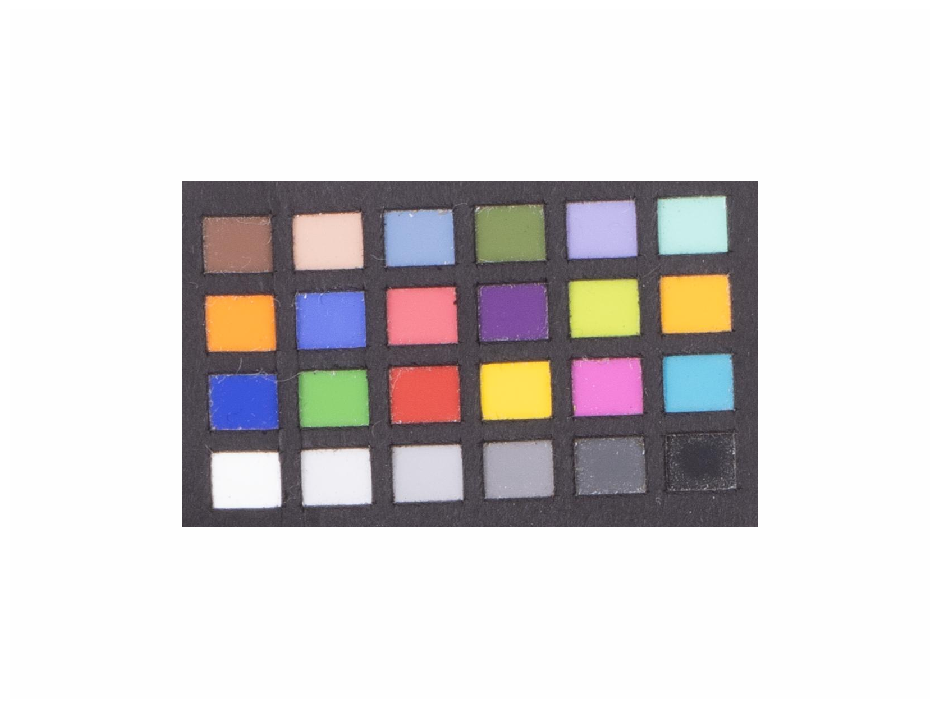

In [5]:
# Get into the color test folder
COLOR_FOLDER = "ColorTest/"
search_pattern = os.path.join(COLOR_FOLDER, "*.[jp][pg]*")

# 2. Get all image paths
COLOUR_CHECKER_IMAGE_PATHS = glob.glob(search_pattern)

# Reference the paths to images
COLOUR_CHECKER_IMAGES = []

for path in COLOUR_CHECKER_IMAGE_PATHS:
    try:
        # 1. Load the image
        img = colour.io.read_image(path)
        h, w = img.shape[:2]
        
        # 2. Calculate the 2% trim (per side)
        h_trim = int(h * 0.05)
        w_trim = int(w * 0.05)
        
        # 3. Trim the image using slicing [start_y:end_y, start_x:end_x]
        trimmed_img = img[h_trim:h-h_trim, w_trim:w-w_trim]
        
        # 4. Calculate padding based on the NEW width
        new_w = trimmed_img.shape[1]
        pad_size = int(new_w * 0.30)
        
        # 5. Add the white border
        padded_img = cv2.copyMakeBorder(
            trimmed_img, 
            top=pad_size, 
            bottom=pad_size, 
            left=pad_size, 
            right=pad_size, 
            borderType=cv2.BORDER_CONSTANT, 
            value=[1, 1, 1]  # Pure white for float images
        )
        
        # 6. Linearize and store
        linear_img = colour.cctf_decoding(padded_img)
        COLOUR_CHECKER_IMAGES.append(linear_img)
        
        print(f"Trimmed (2%) and Padded (30%): {path}")
        
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Plot the images       
for image in COLOUR_CHECKER_IMAGES:
    colour.plotting.plot_image(colour.cctf_encoding(image))

# Detection

In [8]:
# Inference
"""
SWATCHES = []
for image in COLOUR_CHECKER_IMAGES:
    SWATCHES.extend(detect_colour_checkers_inference(image, show=True))
"""

# Segmentation
"""
SWATCHES = []
for image in COLOUR_CHECKER_IMAGES:
    SWATCHES.extend(detect_colour_checkers_segmentation(image, show=True))
"""

# Templating
SWATCHES = []
for image in COLOUR_CHECKER_IMAGES:
    SWATCHES.extend(detect_colour_checkers_templated(image, show=True))

KeyError: 'scikit-learn'

In [7]:
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.8.0


# Color Fitting

In [42]:
D65 = colour.CCS_ILLUMINANTS["CIE 1931 2 Degree Standard Observer"]["D65"]
REFERENCE_COLOUR_CHECKER = colour.CCS_COLOURCHECKERS[
    "ColorChecker24 - After November 2014"
]

colour_checker_rows = REFERENCE_COLOUR_CHECKER.rows
colour_checker_columns = REFERENCE_COLOUR_CHECKER.columns

# NOTE: The reference swatches values as produced by the "colour.XYZ_to_RGB"
# definition are linear by default.
# See https://github.com/colour-science/colour-checker-detection/discussions/59
# for more information.
REFERENCE_SWATCHES = colour.XYZ_to_RGB(
    colour.xyY_to_XYZ(list(REFERENCE_COLOUR_CHECKER.data.values())),
    "sRGB",
    REFERENCE_COLOUR_CHECKER.illuminant,
)

for i, swatches in enumerate(SWATCHES):
    swatches_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(swatches, "sRGB", D65))

    colour_checker = colour.characterisation.ColourChecker(
        os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i]),
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_xyY, strict=False)),
        D65,
        colour_checker_rows,
        colour_checker_columns,
    )

    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker]
    )

    swatches_f = colour.colour_correction(swatches, swatches, REFERENCE_SWATCHES)
    swatches_f_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(swatches_f, "sRGB", D65))
    colour_checker = colour.characterisation.ColourChecker(
        f"{os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i])} - CC",
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_f_xyY, strict=False)),
        D65,
        colour_checker_rows,
        colour_checker_columns,
    )

    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker]
    )

    colour.plotting.plot_image(
        colour.cctf_encoding(
            colour.colour_correction(
                COLOUR_CHECKER_IMAGES[i], swatches, REFERENCE_SWATCHES
            )
        )
    )